In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt


## Energy Activations 

### Three arguments:
   * weights: (theta) parameters of the convnet
   * U(x; theta): energy, indirectly depends on parameters theta
   * x: sample

### Two gradients:
   * langevin steps update
   * gradient to update theta

### (One) Positive vs negative samples:
   * positive: increases the probability of training data by reducing corresponding free energy
   * negative: decreases the probability of samples generated by the model

As training progresses, negative samples should look like samples from the training set as the estimation becomes closer to true underlying distribution.

In [15]:
class EnergyModel(nn.Module):
    def __init__(self, size, type = 'relu'):
        super(EnergyModel, self).__init__()
        self.size = size
        self.lr = 0.0005
        self.type = type

        # initialize energy model parameters theta
        hidden_size = 512 

        self.run_relu = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.size),
            nn.ReLU()
        )

        self.run_tanh = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, self.size),
            nn.Tanh()
        )

        self.run_softplus = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, self.size),
            nn.Softplus()
        )

        self.run_sigmoid = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, self.size),
            nn.Sigmoid()
        )

        self.run_leakyrelu = nn.Sequential(
            nn.Linear(self.size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, self.size),
            nn.LeakyReLU(0.2)
        )

        self.optim = torch.optim.Adam(self.parameters(), lr = self.lr)


    # careful to add activation or else it becomes regular linear multiplication
    def forward(self, x):
        if self.type == 'tanh':
            x = self.run_tanh(x)
        elif self.type == 'softplus':
            x = self.run_softplus(x)
        elif self.type == 'leaky_relu':
            x = self.run_leakyrelu(x)
        elif self.type == 'sigmoid':
            x = self.run_sigmoid(x)
        else:
            x = self.run_relu(x)

        return x


    # energy function
    def U(self, x):
        return -1.0 * self.forward(x).sum()


    def go(self, data1, data2, epoch, pos_data, neg_data):
        energy_data = []
        self.train()

        # initialize variables from positive sample and negative sample of normal distribution
        # x_pos comes with sample data (X_train)
        # x_neg needs to be sampled from the starting values (X_demo)
        x_pos = torch.autograd.Variable((torch.tensor(data1, dtype = torch.float32)),
                requires_grad = True)
        x_neg = torch.autograd.Variable((torch.tensor(data2, dtype = torch.float32)),
                requires_grad = True)

        # update samples via stochastic gradient Langevin dynamics
        # use langevin to sample -- use x_neg as starting point and update it with gradient after every step
        # gradient of the energy function
        langevin_step_size = 0.001
        langevin_steps = 35
        for j in range(langevin_steps):
            x_neg_eng = self.U(x_neg)
            energy_data.append(x_neg_eng)
            x_neg_grad = torch.autograd.grad(x_neg_eng, x_neg)[0] # given theta and data
            noise = torch.sqrt(torch.tensor(0.5 * langevin_step_size)) * torch.randn_like(x_neg)
            x_neg.data = x_neg.data + 1.0 * (langevin_step_size) * (-x_neg_grad.data) + (noise)

        # goal: minimize energy by minimizing U(x_pos) and maximizing U(x_neg) [max x_pos and min x_neg]
        #       x_pos is the sample data
        #       x_neg is the data from repeated langevin steps
        # apply energy to each dataset to discover an energy function that
        # assigns low values to high probability events and vice versa
        self.optim.zero_grad()
        loss = self.U(x_pos) - self.U(x_neg)
        loss.backward()
        self.optim.step() # updating parameters
        self.eval()

        pos_data.append(self.U(x_pos).detach())
        neg_data.append(self.U(x_neg).detach())
        
        print("Loss: ", loss.data)
        #i epoch >= 50
        #   visualize(energy_data, epoch)

In [3]:
def visualize(data, epoch):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(data, dtype=torch.float)
    plt.title('Results on Epoch ' + str(epoch + 1))
    plt.xlabel('Steps')
    plt.ylabel('Energy')

    plt.plot(durations_t.numpy())
    plt.show()


def visualize_data(data):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(data, dtype=torch.float)
    plt.title('Results over Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Energy')

    plt.plot(durations_t.numpy())
    plt.show()

In [21]:
size = 500
epoch = 200

mean_arr1 = np.array((0, 0, 0))
mean_arr2 = np.array((0, 0, 0))
cov = np.array(([1, 0, 0], [0, 1, 0], [0, 0, 1]))
cov2 = np.array(([50, 0, 0], [0, 50, 0], [0, 0, 50]))
    

Loss:  tensor(-17.9951)
Loss:  tensor(-9.1787)
Loss:  tensor(4.5003)
Loss:  tensor(56.8877)
Loss:  tensor(14.1902)
Loss:  tensor(8.8522)
Loss:  tensor(24.6971)
Loss:  tensor(41.6035)
Loss:  tensor(16.7243)
Loss:  tensor(22.5465)
Loss:  tensor(44.4398)
Loss:  tensor(-28.9601)
Loss:  tensor(-30.4942)
Loss:  tensor(52.3358)
Loss:  tensor(31.5842)
Loss:  tensor(5.9311)
Loss:  tensor(85.4216)
Loss:  tensor(96.1869)
Loss:  tensor(26.6608)
Loss:  tensor(103.3201)
Loss:  tensor(-52.8882)
Loss:  tensor(-15.8703)
Loss:  tensor(33.0224)
Loss:  tensor(-10.5131)
Loss:  tensor(15.8048)
Loss:  tensor(89.7136)
Loss:  tensor(55.9785)
Loss:  tensor(55.2126)
Loss:  tensor(115.3585)
Loss:  tensor(-66.9657)
Loss:  tensor(57.8410)
Loss:  tensor(32.9868)
Loss:  tensor(117.1534)
Loss:  tensor(201.5320)
Loss:  tensor(69.1126)
Loss:  tensor(58.3752)
Loss:  tensor(222.8152)
Loss:  tensor(-45.2756)
Loss:  tensor(131.1506)
Loss:  tensor(139.8259)
Loss:  tensor(23.5731)
Loss:  tensor(98.8545)
Loss:  tensor(186.0334

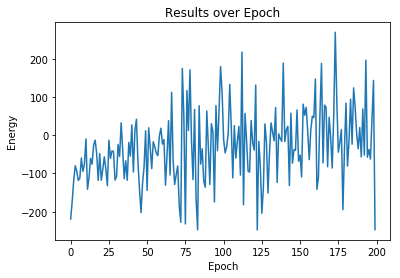

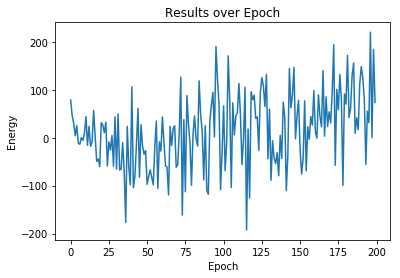

In [22]:
model = EnergyModel(size, 'tanh')
pos_data = []
neg_data = []

for i in range(epoch):
    # sample = np.random.normal(mean1, var1, size)
    # sample2 = np.random.normal(mean2, var2, size)

    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-5.1229)
Loss:  tensor(-47.7703)
Loss:  tensor(-89.4991)
Loss:  tensor(-272.7234)
Loss:  tensor(-408.7953)
Loss:  tensor(-599.8794)
Loss:  tensor(-1115.6669)
Loss:  tensor(-1824.1354)
Loss:  tensor(-2195.7161)
Loss:  tensor(-3515.1023)
Loss:  tensor(-4196.9238)
Loss:  tensor(-5578.8911)
Loss:  tensor(-7165.9810)
Loss:  tensor(-9900.9336)
Loss:  tensor(-12697.2627)
Loss:  tensor(-14549.5039)
Loss:  tensor(-14975.0645)
Loss:  tensor(-23633.3594)
Loss:  tensor(-22149.9863)
Loss:  tensor(-27348.9766)
Loss:  tensor(-29194.4727)
Loss:  tensor(-36446.2539)
Loss:  tensor(-37890.7969)
Loss:  tensor(-46937.1055)
Loss:  tensor(-41642.7656)
Loss:  tensor(-46592.3828)
Loss:  tensor(-33905.2188)
Loss:  tensor(-43645.5469)
Loss:  tensor(-50751.6719)
Loss:  tensor(-53599.6875)
Loss:  tensor(-62581.7656)
Loss:  tensor(-27190.6094)
Loss:  tensor(-55744.2344)
Loss:  tensor(-58777.9062)
Loss:  tensor(-55819.6875)
Loss:  tensor(-91678.3438)
Loss:  tensor(-100436.0625)
Loss:  tensor(-124876.75

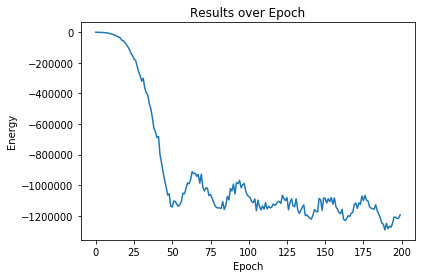

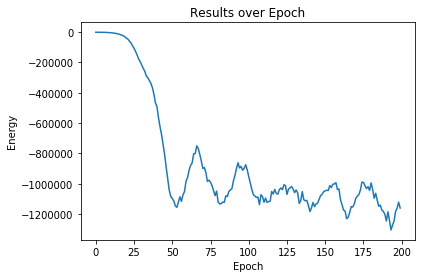

In [62]:
model = EnergyModel(size, 'softplus')
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-107.1718)
Loss:  tensor(-168.6399)
Loss:  tensor(-254.2778)
Loss:  tensor(-420.7331)
Loss:  tensor(-668.5062)
Loss:  tensor(-950.9099)
Loss:  tensor(-1041.7595)
Loss:  tensor(-1630.5747)
Loss:  tensor(-2787.6165)
Loss:  tensor(-3211.1450)
Loss:  tensor(-4211.2500)
Loss:  tensor(-5799.7871)
Loss:  tensor(-8246.4580)
Loss:  tensor(-10128.5479)
Loss:  tensor(-12809.1768)
Loss:  tensor(-15316.9941)
Loss:  tensor(-19524.8711)
Loss:  tensor(-20065.6133)
Loss:  tensor(-27641.6055)
Loss:  tensor(-27367.5176)
Loss:  tensor(-25193.1523)
Loss:  tensor(-20874.7383)
Loss:  tensor(-16532.1719)
Loss:  tensor(-17910.8359)
Loss:  tensor(-15471.5312)
Loss:  tensor(-12591.0781)
Loss:  tensor(-21551.6953)
Loss:  tensor(-16876.0938)
Loss:  tensor(-19793.1016)
Loss:  tensor(-12424.2188)
Loss:  tensor(-54196.7500)
Loss:  tensor(-33211.9219)
Loss:  tensor(-49026.8438)
Loss:  tensor(-15294.6094)
Loss:  tensor(-46305.3125)
Loss:  tensor(-39842.3281)
Loss:  tensor(-41765.9375)
Loss:  tensor(-35431

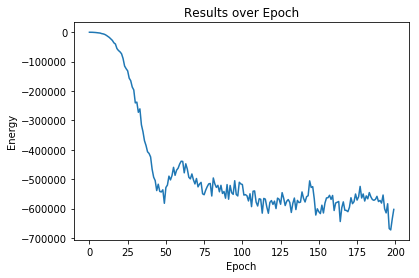

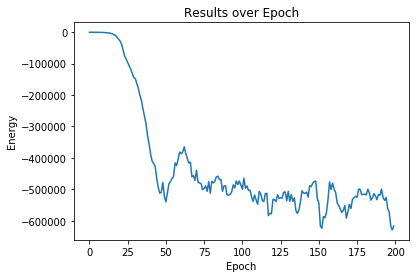

In [63]:
model = EnergyModel(size, 'leaky_relu')
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(-0.3888)
Loss:  tensor(0.9373)
Loss:  tensor(1.2615)
Loss:  tensor(-1.1474)
Loss:  tensor(-5.9104)
Loss:  tensor(-2.1558)
Loss:  tensor(8.5305)
Loss:  tensor(-5.8774)
Loss:  tensor(-4.5074)
Loss:  tensor(-4.0590)
Loss:  tensor(-9.6608)
Loss:  tensor(1.0361)
Loss:  tensor(1.5673)
Loss:  tensor(1.6847)
Loss:  tensor(7.2191)
Loss:  tensor(-1.4271)
Loss:  tensor(2.4641)
Loss:  tensor(-7.5364)
Loss:  tensor(-6.6235)
Loss:  tensor(25.2645)
Loss:  tensor(11.0745)
Loss:  tensor(10.2151)
Loss:  tensor(-9.5328)
Loss:  tensor(7.0739)
Loss:  tensor(-5.5421)
Loss:  tensor(10.0706)
Loss:  tensor(5.0232)
Loss:  tensor(15.7071)
Loss:  tensor(30.5359)
Loss:  tensor(-7.5015)
Loss:  tensor(-25.6895)
Loss:  tensor(11.1792)
Loss:  tensor(-7.3282)
Loss:  tensor(-2.0157)
Loss:  tensor(-4.7504)
Loss:  tensor(17.5515)
Loss:  tensor(-7.9049)
Loss:  tensor(1.4841)
Loss:  tensor(-8.5078)
Loss:  tensor(-15.4561)
Loss:  tensor(-20.0038)
Loss:  tensor(-15.9873)
Loss:  tensor(1.8025)
Loss:  tensor(8.427

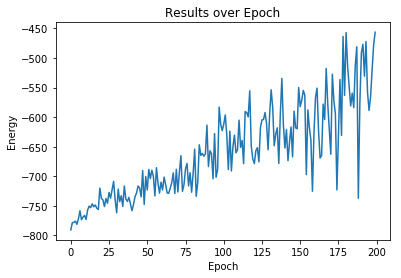

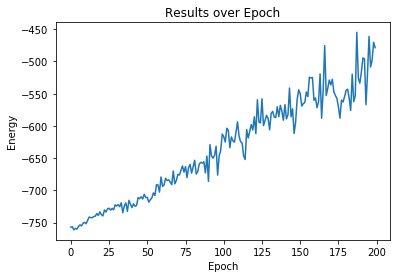

In [23]:
model = EnergyModel(size, 'sigmoid')
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)

Loss:  tensor(933.1793)
Loss:  tensor(794.1047)
Loss:  tensor(663.4503)
Loss:  tensor(532.2646)
Loss:  tensor(475.2476)
Loss:  tensor(368.3661)
Loss:  tensor(280.5582)
Loss:  tensor(221.9736)
Loss:  tensor(207.9305)
Loss:  tensor(116.8138)
Loss:  tensor(106.6198)
Loss:  tensor(110.8154)
Loss:  tensor(81.1508)
Loss:  tensor(51.8386)
Loss:  tensor(41.3172)
Loss:  tensor(48.7250)
Loss:  tensor(53.3318)
Loss:  tensor(31.1429)
Loss:  tensor(21.4079)
Loss:  tensor(20.5861)
Loss:  tensor(14.7425)
Loss:  tensor(17.2672)
Loss:  tensor(14.9197)
Loss:  tensor(13.2781)
Loss:  tensor(16.7030)
Loss:  tensor(13.6503)
Loss:  tensor(2.7769)
Loss:  tensor(3.8092)
Loss:  tensor(10.7346)
Loss:  tensor(6.3649)
Loss:  tensor(13.6543)
Loss:  tensor(8.2903)
Loss:  tensor(1.6216)
Loss:  tensor(6.5667)
Loss:  tensor(8.5908)
Loss:  tensor(5.5543)
Loss:  tensor(-0.7334)
Loss:  tensor(2.1336)
Loss:  tensor(6.1832)
Loss:  tensor(4.4271)
Loss:  tensor(3.9579)
Loss:  tensor(3.7828)
Loss:  tensor(4.1779)
Loss:  tensor

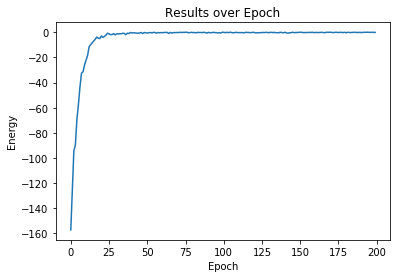

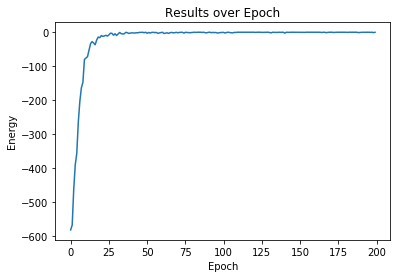

In [20]:
model = EnergyModel(size) # relu 
pos_data = []
neg_data = []

for i in range(epoch):
    center = np.random.multivariate_normal(mean_arr1, cov, size)
    center = center.transpose()

    sphere = np.random.multivariate_normal(mean_arr2, cov2, size)
    sphere = sphere.transpose()

    # Now, either train the model and start a negative sample from the origin.
    # Will it travel all the way to the positive samples near the sphere?
    # For softplus() it should be the case, for relu() not.
    model.go(sphere, center, i, pos_data, neg_data)


visualize_data(pos_data)
visualize_data(neg_data)